# Notebook to look at potential splay states in power MN activity

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import glob
import pickle
# import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.spatial.distance import cdist
from scipy.stats import median_abs_deviation

from sklearn.cluster import KMeans

from neo.io import Spike2IO

# from matplotlib import rcParams
from mosquito.process_abf import (load_processed_data, cluster_spikes, save_processed_data, detect_spikes, estimate_spike_rate, 
                                   detrend_emg, filter_emg)
from mosquito.util import set_plot_params, my_adjust_axes, my_add_scalebar


## Params

In [3]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels


## Helper function

In [4]:
def get_pairwise_phase(spike_times, spike_times_ref):
    """
    For two arrays of spike times (spike_times and spike_times_ref), determine the phase of 
    spike_times relative to the spike_times_ref. 

    Here, phase is in [0, 1]
    
    """
    # initialize some storage
    phases = list()

    # loop over spikes in x
    for spike_time in spike_times:
        # find the events in spike_times_ref bracketing current spike
        spike_times_ref_pre = spike_times_ref[spike_times_ref <= spike_time]
        spike_times_ref_post = spike_times_ref[spike_times_ref > spike_time]

        # check that we have bracketing events
        if (spike_times_ref_pre.size == 0) or (spike_times_ref_post.size == 0):
            phase = np.nan
        else:
            # if we have ref events on either side, get phase
            spike_time_ref_pre = spike_times_ref_pre[-1]
            spike_time_ref_post = spike_times_ref_post[0]
            phase = (spike_time - spike_time_ref_pre)/(spike_time_ref_post - spike_time_ref_pre)

        # add to list
        phases.append(phase)
        
    # return array
    return np.asarray(phases)
    

In [5]:
def plot_spike_raster(spike_times_list, ax=None, xlim=None,colors=['r', 'y', 'orange', 'chocolate'], labels=None):
    """
    Given a list containing multiple arrays of spike times, plot the spike times as a raster

    """
    # make sure we have an axis object
    if ax is None:
        fig, ax = plt.subplots()

    # get extent of raster lines on y-axis 
    line_boundaries = np.linspace(0, 1, len(spike_times_all) + 1)
    boundary_ctrs = (line_boundaries[:-1] + line_boundaries[1:])/2.0


    # loop over spike time lists
    for ith, spike_times in enumerate(spike_times_list):
        # current boundaries for raster lines
        ymin = line_boundaries[ith+1]
        ymax = line_boundaries[ith]

        spike_times_curr = spike_times.copy()
        if xlim is not None:
            spike_times_curr =  spike_times_curr[(spike_times_curr >= xlim[0]) & (spike_times_curr <= xlim[1])]
       
            
        # loop over spikes
        for st in spike_times:
            ax.axvline(st, ymin=ymin, ymax=ymax, color=colors[ith])

    # set labels if we have them
    if labels is not None:
        ax.set_yticks(boundary_ctrs, labels=labels)

    # set x (time) limits if we have them
    if xlim is not None:
        ax.set_xlim(xlim)
        
    return ax
    

## Want to first look at interesting case with 3 detectable units

In [6]:
# load data file
data_folder = 16
axo_num = 0

data = load_processed_data(data_folder, axo_num)


In [7]:
# read out data
t = data['time']
emg = data['emg']
emg_filt = data['emg_filt']
spike_idx = data['spike_idx']
spikes = data['spikes']
spike_t = data['spike_t']

fs = data['sampling_freq']
window = data['params']['emg_window']
offset = data['params']['emg_offset']


Text(0, 0.5, 'emg (V)')

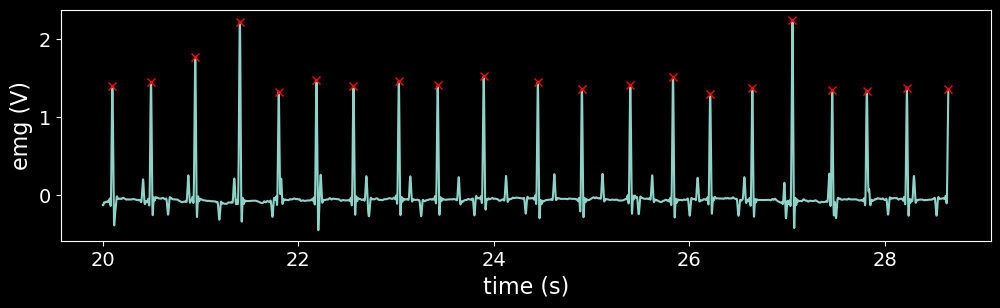

In [8]:
# plot a chunk of data
tmin = 20
tmax = 28.65
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

Text(0, 0.5, 'emg (V)')

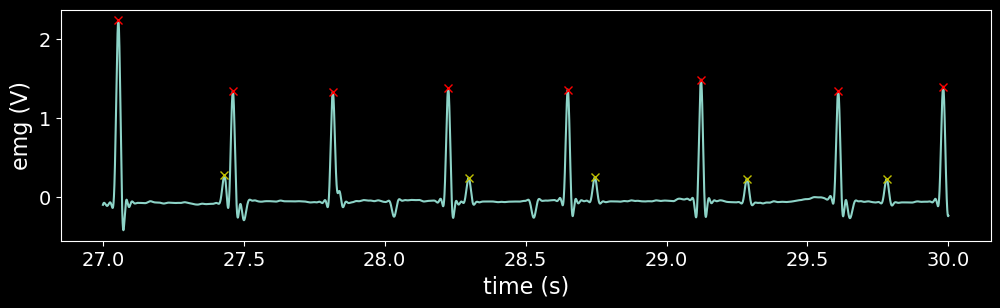

In [9]:
# we're getting large, positive spikes. can we get small ones as well?
spikes_small, spike_t_small, spike_idx_small = detect_spikes(emg_filt, fs, thresh_factors=(1.0, 5.0), viz_flag=False, 
                                                             remove_edge_case_flag=False, recenter_window_factor=0.125)

# visualize
tmin = 27
tmax = 30
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)
mask_spikes_small = (t[spike_idx_small] >= tmin) & (t[spike_idx_small] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')
ax.plot(t[spike_idx_small][mask_spikes_small], emg_filt[spike_idx_small][mask_spikes_small], 'yx')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

# ax.set_ylim([0, 0.5])

Text(0, 0.5, 'emg (V)')

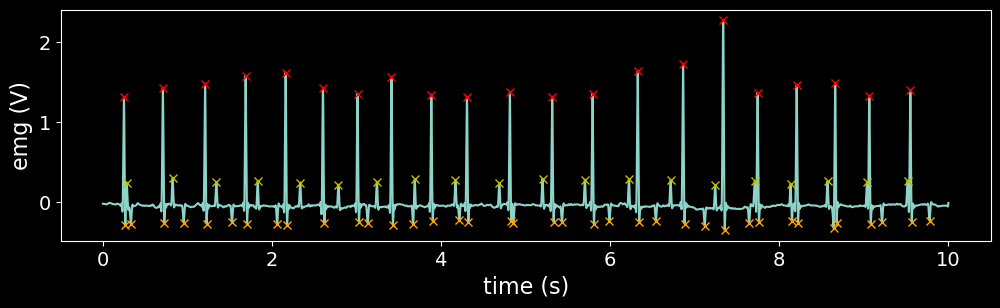

In [10]:
# we're getting large and small positive spikes. can we get negative ones as well?
spikes_neg, spike_t_neg, spike_idx_neg = detect_spikes(-1*emg_filt, fs, thresh_factors=(2.0, 5.0), viz_flag=False, 
                                                             remove_edge_case_flag=False, recenter_window_factor=0.125)
    
# visualize
tmin = 0
tmax = 10
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)
mask_spikes_small = (t[spike_idx_small] >= tmin) & (t[spike_idx_small] <= tmax)
mask_spikes_neg = (t[spike_idx_neg] >= tmin) & (t[spike_idx_neg] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')
ax.plot(t[spike_idx_small][mask_spikes_small], emg_filt[spike_idx_small][mask_spikes_small], 'yx')
ax.plot(t[spike_idx_neg][mask_spikes_neg], emg_filt[spike_idx_neg][mask_spikes_neg], 'x', color='orange')

# ax.set_ylim([0, 0.5])
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

## Need to remove the detected events that are just the downswing of the big, positive spikes

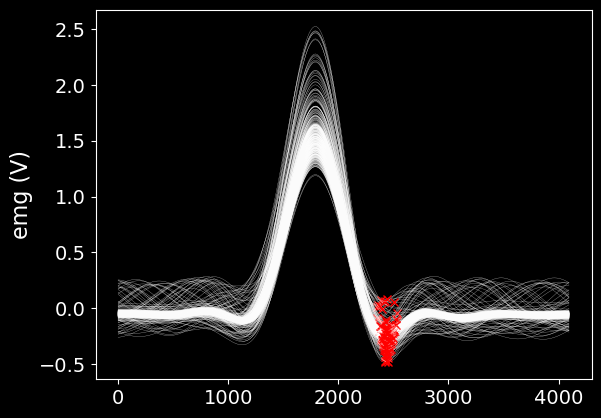

In [11]:
# find post-peak minima in the 'spikes' list
post_peak_minima = list()

# confirm that each large, positive spike has a small, negative overshoot
fig, ax = plt.subplots()
t_samp = np.arange(spikes[0].size)

for idx, spike in zip(spike_idx, spikes):
    # plot waveform
    ax.plot(t_samp, spike, 'w-', alpha=0.8, lw=0.2)

    # find minimum
    pks, prop = find_peaks(-1*spike)
    pks = pks[(pks > window) & (pks < (window + 500))]

    if pks.size > 0:
        pk = pks[0]
        ax.plot(t_samp[pk], spike[pk], 'rx')
    else:
        pk = np.nan

    # convert pk from window units to dataset units
    pk_data = idx + (pk - window) + offset 
    post_peak_minima.append(pk_data)
    
# ax.set_xlabel('time (ms)')
ax.set_ylabel('emg (V)')

post_peak_minima = np.asarray(post_peak_minima)


Text(0, 0.5, 'emg (V)')

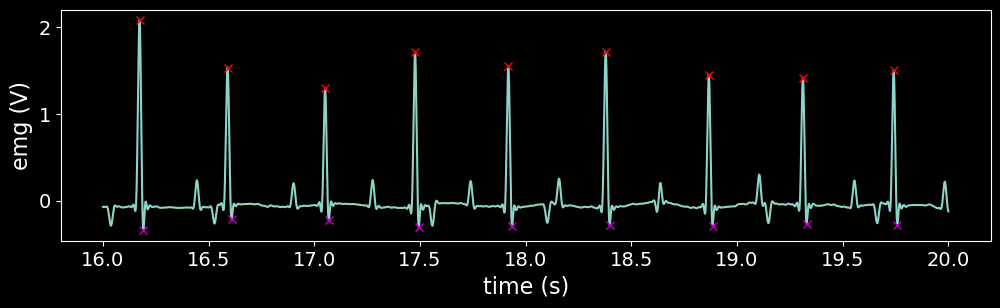

In [12]:
# test that we got the right global points
post_peak_idx = post_peak_minima.copy()
post_peak_idx = post_peak_idx[~np.isnan(post_peak_idx)]
post_peak_idx = post_peak_idx.astype('int')

tmin = 16
tmax = 20
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)
mask_ppm = (t[post_peak_idx] >= tmin) & (t[post_peak_idx] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')
ax.plot(t[post_peak_idx][mask_ppm], emg_filt[post_peak_idx][mask_ppm], 'mx')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

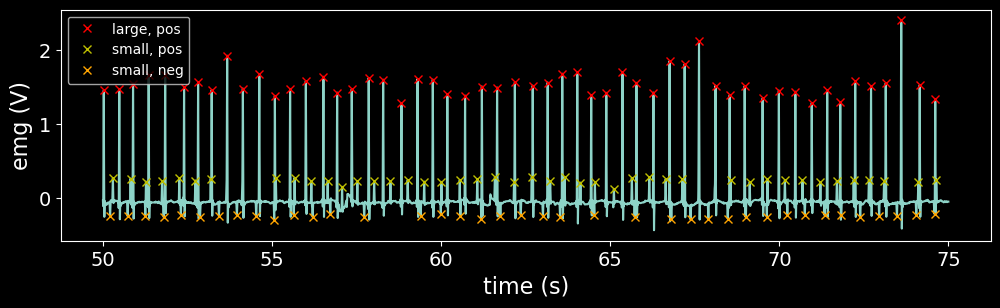

In [13]:
# npw try again on the small, negative spikes, this time excluding post-big-spike minima
spikes_neg, spike_t_neg, spike_idx_neg = detect_spikes(-1*emg_filt, fs, thresh_factors=(1.75, 5.0), viz_flag=False, 
                                                             remove_edge_case_flag=False, recenter_window_factor=0.06)


# remove post-peak minima
idx_dist = np.subtract.outer(spike_idx_neg, post_peak_idx)
idx_dist_min = np.min(np.abs(idx_dist), axis=1)
exclude_idx = (idx_dist_min < 20)
spike_idx_neg = spike_idx_neg[~exclude_idx]

# visualize
tmin = 50
tmax = 75
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)
mask_spikes_small = (t[spike_idx_small] >= tmin) & (t[spike_idx_small] <= tmax)
mask_spikes_neg = (t[spike_idx_neg] >= tmin) & (t[spike_idx_neg] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx', label='large, pos')
ax.plot(t[spike_idx_small][mask_spikes_small], emg_filt[spike_idx_small][mask_spikes_small], 'yx', label='small, pos')
ax.plot(t[spike_idx_neg][mask_spikes_neg], emg_filt[spike_idx_neg][mask_spikes_neg], 'x', color='orange', label='small, neg')

# ax.set_ylim([0, 0.5])
ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')
ax.legend()

## Can do a few simple things now
1) Visualize the spikes as a raster to see if splay states pop out
2) Using the large, positive spikes as a clock, see how consistently order between small spikes is maintained
3) Look at phase over time of small spikes wrt big spikes
4) Look at firing frequency of each unit
  

Text(0.5, 0, 'time (s)')

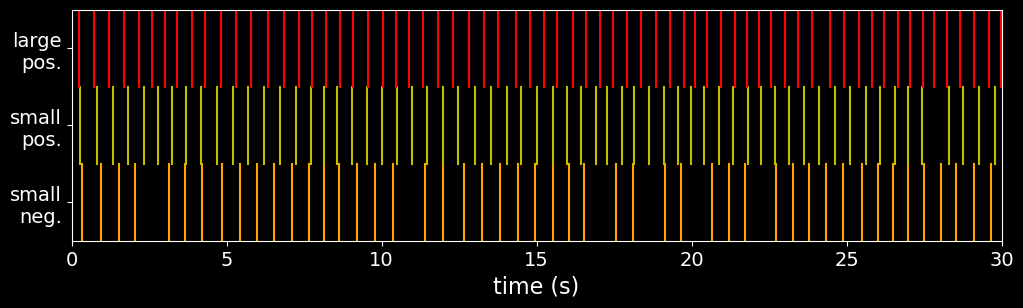

In [14]:
# visualize as raster
fig, ax = plt.subplots(figsize=(12, 3))

spike_times_all = [t[spike_idx_neg], t[spike_idx_small], t[spike_idx]]
colors = ['orange', 'y', 'r']
labels = ['small\nneg.', 'small\npos.', 'large\npos.']
xlim = [0, 30]

ax = plot_spike_raster(spike_times_all, ax=ax, labels=labels, colors=colors, xlim=xlim)
ax.set_xlabel('time (s)')

Text(0, 0.5, 'state')

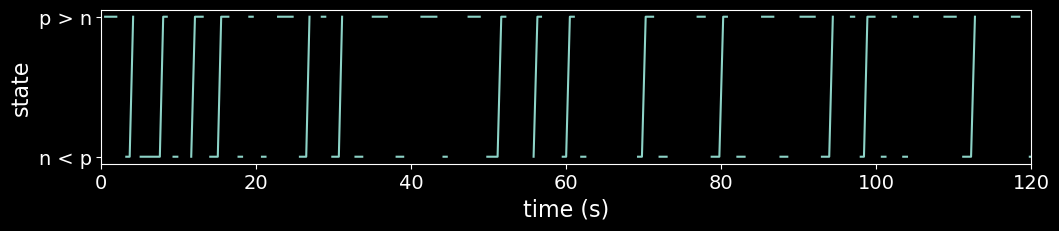

In [15]:
# Look at order of small positive vs negative spikes relative to large positive
# code for states: 1 = postive before negative; 0 = negative before positive; nan = missing one
states = list()
interval_ctrs = list()

for ith in range(len(spike_idx) - 1):
    # get indices for large spikes that bracket current interval
    start_ind = spike_idx[ith]
    end_ind = spike_idx[ith + 1]

    # record interval center
    interval_ctr = int((start_ind + end_ind)/2.0)
    interval_ctrs.append(interval_ctr)
    
    # get index of small spikes in this interval
    pos_idx = spike_idx_small[(spike_idx_small > start_ind) & (spike_idx_small < end_ind)]
    neg_idx = spike_idx_neg[(spike_idx_neg > start_ind) & (spike_idx_neg < end_ind)]

    # determine state based on order of these two
    if (pos_idx.size != 1) or (neg_idx.size != 1):
        states.append(np.nan)
    else:
        states.append(pos_idx[0] < neg_idx[0])


# convert to array 
states = np.asarray(states)
interval_ctrs = np.asarray(interval_ctrs)

# visualize!
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(t[interval_ctrs], states, '-')
# ax.set_axis_off()
ax.set_xlim([0, 120])

ax.set_yticks([0, 1], labels=['n < p', 'p > n'])
ax.set_xlabel('time (s)')
ax.set_ylabel('state')


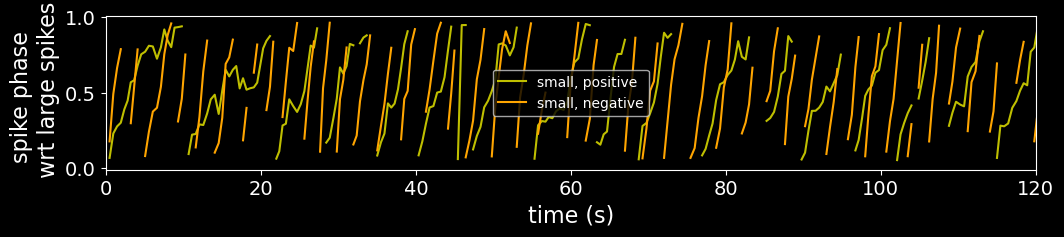

In [16]:
# phase of small spikes relative to large spikes
small_phases = list()
neg_phases = list()
interval_ctrs = list()

for ith in range(len(spike_idx) - 1):
    # get indices for large spikes that bracket current interval
    start_ind = spike_idx[ith]
    end_ind = spike_idx[ith + 1]

    # record interval center
    interval_ctr = int((start_ind + end_ind)/2.0)
    interval_ctrs.append(interval_ctr)
    
    # get index of small spikes in this interval
    pos_idx = spike_idx_small[(spike_idx_small > start_ind) & (spike_idx_small < end_ind)]
    neg_idx = spike_idx_neg[(spike_idx_neg > start_ind) & (spike_idx_neg < end_ind)]

    # get "phases" of these smaller spikes
    if pos_idx.size != 1:
        # print(f'no small, positive spike near {t[start_ind]}')
        small_phase = np.nan
    else:
        small_phase = (pos_idx[0] - start_ind)/(end_ind - start_ind)

    small_phases.append(small_phase)

    if neg_idx.size != 1:
        # print('no small, negative spike')
        neg_phase = np.nan
    else:
        neg_phase = (neg_idx[0] - start_ind)/(end_ind - start_ind)

    neg_phases.append(neg_phase)

# convert to arrays
small_phases = np.asarray(small_phases)
neg_phases = np.asarray(neg_phases)
interval_ctrs = np.asarray(interval_ctrs)

# visualize!
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(t[interval_ctrs], small_phases, color='y', label='small, positive')
ax.plot(t[interval_ctrs], neg_phases, color='orange', label='small, negative')
ax.set_xlim([0, 120])

ax.set_xlabel('time (s)')
ax.set_ylabel('spike phase \n wrt large spikes')
ax.legend()

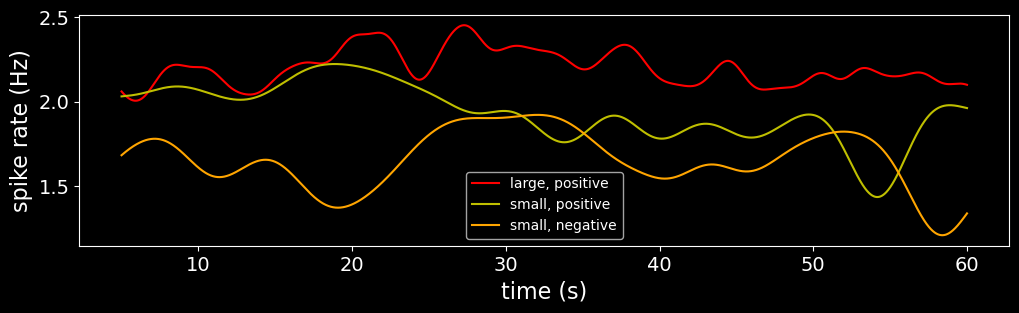

In [17]:
# intantaneous spike rate for each unit
spike_rate = estimate_spike_rate(spike_idx, fs, t.size, win_factor=2)
spike_rate_small = estimate_spike_rate(spike_idx_small, fs, t.size, win_factor=2)
spike_rate_neg = estimate_spike_rate(spike_idx_neg, fs, t.size, win_factor=2)

fig, ax = plt.subplots(figsize=(12, 3))

tmin = 5
tmax = 60
mask = (t >= tmin) & (t <= tmax)

ax.plot(t[mask], spike_rate[mask], color='r', label='large, positive')
ax.plot(t[mask], spike_rate_small[mask], color='y', label='small, positive')
ax.plot(t[mask], spike_rate_neg[mask], color='orange', label='small, negative')

ax.set_xlabel('time (s)')
ax.set_ylabel('spike rate (Hz)')
ax.legend()

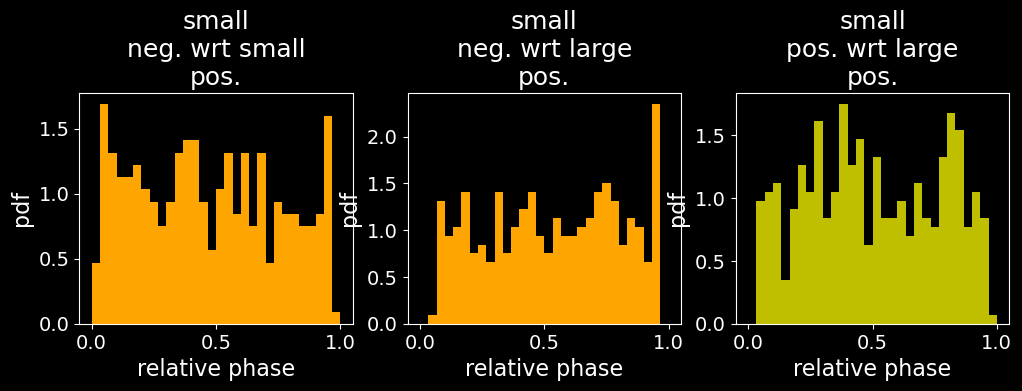

In [18]:
# look at pairwise phase histograms
spike_times_list = [t[spike_idx_neg], t[spike_idx_small], t[spike_idx]]
colors = ['orange', 'y', 'r']
labels = ['small\nneg.', 'small\npos.', 'large\npos.']

fig, ax_list = plt.subplots(1, 3, figsize=(12,3))
ax_list = ax_list.ravel()
cc = 0
bins = np.linspace(0, 1, 31)
for ith in range(len(spike_times_list)):
    for jth in range(len(spike_times_list)):
        # don't want to double count or get phase with itself
        if ith <= jth:
            continue

        # get phases
        phases_curr = get_pairwise_phase(spike_times_list[jth], spike_times_list[ith])

        # plot
        ax = ax_list[cc]
        ax.hist(phases_curr, bins=bins, density=True, color=colors[jth])
        ax.set_xlabel('relative phase')
        ax.set_ylabel('pdf')
        ax.set_title(f'{labels[jth]} wrt {labels[ith]}')
        cc += 1

## Check out another example data file -- this time Drosophila

In [384]:
# load data file
data_folder = 36
axo_num = 3

data = load_processed_data(data_folder, axo_num)


In [385]:
# read out data
t = data['time']
emg = data['emg']
emg_filt = data['emg_filt']
spike_idx = data['spike_idx']
spikes = data['spikes']
spike_t = data['spike_t']
wbf_mean = data['wbf_mean']

fs = data['sampling_freq']
window = data['params']['emg_window']
offset = data['params']['emg_offset']


Text(0, 0.5, 'emg (V)')

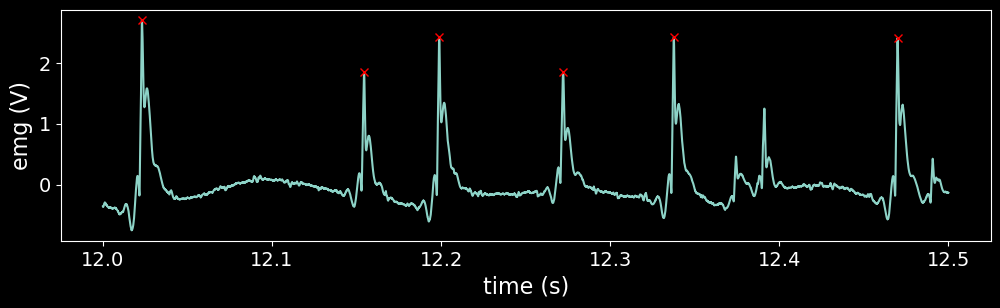

In [386]:
# plot a chunk of data
tmin = 12
tmax = 12.5
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt[spike_idx][mask_spikes], 'rx')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

Text(0, 0.5, 'emg (V)')

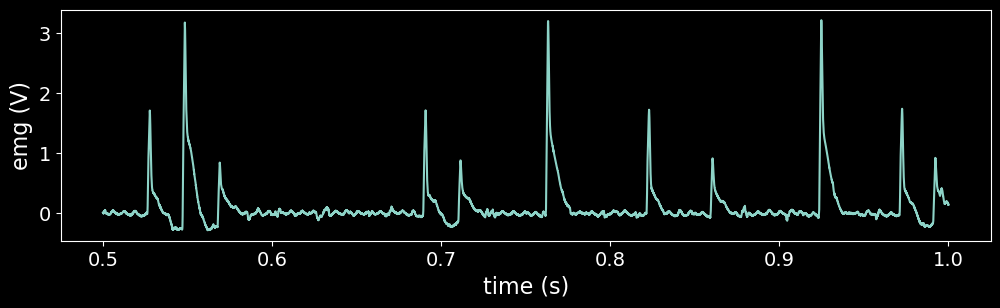

In [387]:
# detrend this data
emg_filt_detrend = detrend_emg(emg, window=int(window/2))

# visualize
tmin = 0.5
tmax = 1.0
mask = (t >= tmin) & (t <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

# ax.plot(t[mask], emg_filt[mask])
ax.plot(t[mask], emg_filt_detrend[mask])

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')

In [388]:
# we're getting large, positive spikes. can we get small ones as well?
spikes_new, spike_t_new, spike_idx_new = detect_spikes(emg_filt_detrend, fs, thresh_factors=(2.5,  8), viz_flag=False, 
                                                       remove_edge_case_flag=True, recenter_window_factor=0.125, 
                                                       thresh_vals=(0.5, 2.5))

# tmin = 0
# tmax = 10
# mask = (t >= tmin) & (t <= tmax)
# spikes_new, spike_t_new, spike_idx_new = detect_spikes(emg_filt_detrend[mask], fs, thresh_factors=(2.5,  8), viz_flag=True, 
#                                                        remove_edge_case_flag=True, recenter_window_factor=0.125, 
#                                                        thresh_vals=(0.5, 2.5))


Text(0, 0.5, 'emg (V)')

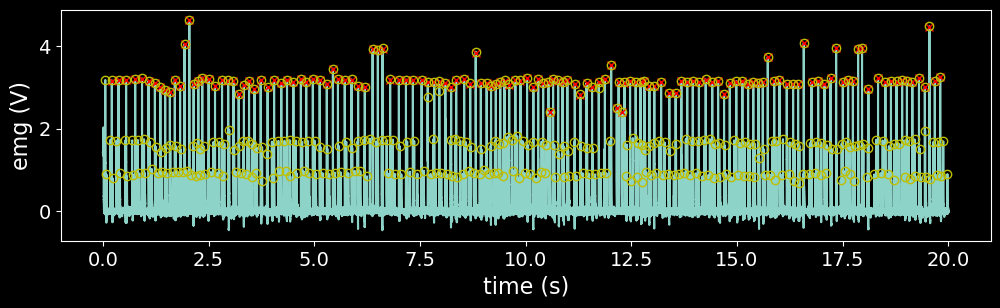

In [389]:
# visualize
tmin = 0
tmax = 20
mask = (t >= tmin) & (t <= tmax)
mask_spikes = (t[spike_idx] >= tmin) & (t[spike_idx] <= tmax)
mask_spikes_new = (t[spike_idx_new] >= tmin) & (t[spike_idx_new] <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt_detrend[mask])
ax.plot(t[spike_idx][mask_spikes], emg_filt_detrend[spike_idx][mask_spikes], 'rx')
ax.plot(t[spike_idx_new][mask_spikes_new], emg_filt_detrend[spike_idx_new][mask_spikes_new], 'yo', fillstyle='none')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')


Text(0, 0.5, 'emg (V)')

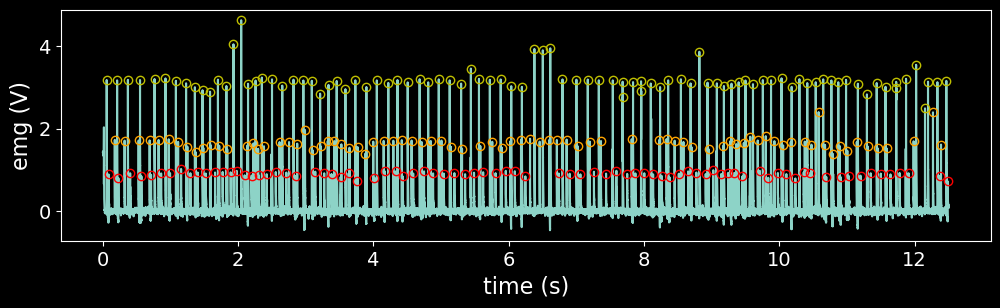

In [390]:
# cluster based on amplitudes
spike_amplitudes = emg_filt_detrend[spike_idx_new] 
# plt.hist(spike_amplitudes, bins=50)

n_clusters = 3
clusterer = KMeans(n_clusters=n_clusters, random_state=47, n_init='auto')
cluster_labels = clusterer.fit_predict(spike_amplitudes.reshape(-1, 1))
colors = ['orange', 'y', 'r']

# visualize
tmin = 0 
tmax = 12.5
mask = (t >= tmin) & (t <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(t[mask], emg_filt_detrend[mask])

for cluster_label in np.unique(cluster_labels):
    spike_idx_tmp = spike_idx_new[cluster_labels == cluster_label]
    mask_tmp = (t[spike_idx_tmp] >= tmin) & (t[spike_idx_tmp] <= tmax)
    ax.plot(t[spike_idx_tmp][mask_tmp], emg_filt_detrend[spike_idx_tmp][mask_tmp], 'o', color=colors[cluster_label], fillstyle='none')

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')


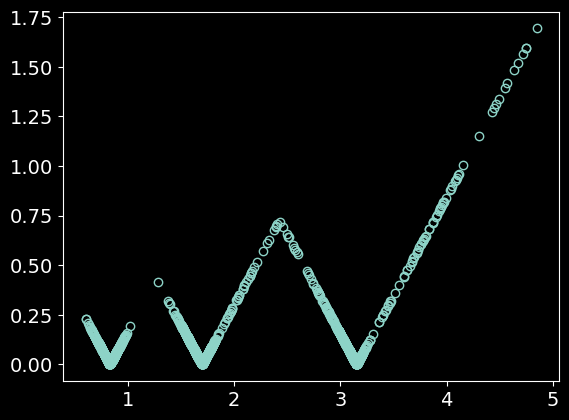

In [391]:
# look at edge cases -- hopefully can do something with this later?
distances = np.abs(np.subtract.outer(spike_amplitudes, clusterer.cluster_centers_))
min_distances = np.min(distances, axis=1)

plt.plot(spike_amplitudes, min_distances, 'o', fillstyle='none')

Text(0.5, 0, 'time (s)')

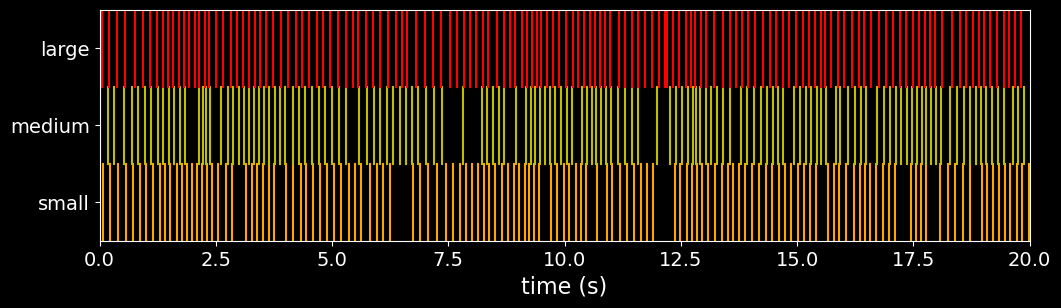

In [392]:
# look at spike times as a raster
cluster_centers = clusterer.cluster_centers_
cluster_centers_sort_idx = np.argsort(np.squeeze(cluster_centers))
spike_times_list = []
for indd in cluster_centers_sort_idx:
    spike_times_list.append(t[spike_idx_new[cluster_labels == indd]])
    
labels = ['small', 'medium', 'large']

# visualize as raster
fig, ax = plt.subplots(figsize=(12, 3))

colors = ['orange', 'y', 'r']
boundary_ctrs = (line_boundaries[:-1] + line_boundaries[1:])/2.0
xlim = [0, 20]

ax = plot_spike_raster(spike_times_list, ax=ax, labels=labels, colors=colors, xlim=xlim)
ax.set_xlabel('time (s)')

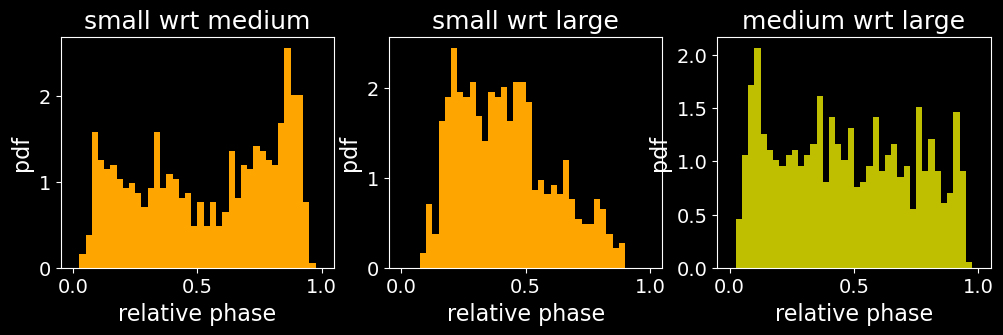

In [393]:
# look at pairwise phase histograms
cluster_centers = clusterer.cluster_centers_
cluster_centers_sort_idx = np.argsort(np.squeeze(cluster_centers))
spike_times_list = []
for indd in cluster_centers_sort_idx:
    spike_times_list.append(t[spike_idx_new[cluster_labels == indd]])

labels = ['small', 'medium', 'large']

fig, ax_list = plt.subplots(1, 3, figsize=(12,3))
ax_list = ax_list.ravel()
cc = 0
bins = np.linspace(0, 1, 41)

for ith in range(len(spike_times_list)):
    for jth in range(len(spike_times_list)):
        # don't want to double count or get phase with itself
        if ith <= jth:
            continue

        # get phases
        phases_curr = get_pairwise_phase(spike_times_list[jth], spike_times_list[ith])

        # plot
        ax = ax_list[cc]
        ax.hist(phases_curr, bins=bins, density=True, color=colors[jth])
        ax.set_xlabel('relative phase')
        ax.set_ylabel('pdf')
        ax.set_title(f'{labels[jth]} wrt {labels[ith]}')
        cc += 1

## How does this compare to Duch Lab data?

In [19]:
# load Duch Lab data
data_path = '/media/sam/SamData/Hurkey_et_al_data/Data Figure 1/Fig 1/Panel A+G'
data_fn = 'figure 1a_original recording.smr'

# load data file
data = Spike2IO(os.path.join(data_path, data_fn)).read()

# read out data from this loaded object
signal = data[0].segments[0].analogsignals[0]
fs = data[0].segments[0].analogsignals[-1].sampling_rate.magnitude.item()
t_duch = signal.times.magnitude
fs

20000.00050524251

In [20]:
# find list indices for different MN spike times
events_name_dict = dict()
for ith, _event in enumerate(data[0].segments[0].events):
    events_name_dict[_event.name] = ith
    print(_event.name)

wb
MN4
MN5
MN3
MN2
MN1


In [31]:
# get spike times for 3 MNs
mn1_spike_times = data[0].segments[0].events[events_name_dict['MN1']].times.magnitude
mn2_spike_times = data[0].segments[0].events[events_name_dict['MN2']].times.magnitude
mn3_spike_times = data[0].segments[0].events[events_name_dict['MN3']].times.magnitude
mn4_spike_times = data[0].segments[0].events[events_name_dict['MN4']].times.magnitude
mn5_spike_times = data[0].segments[0].events[events_name_dict['MN5']].times.magnitude


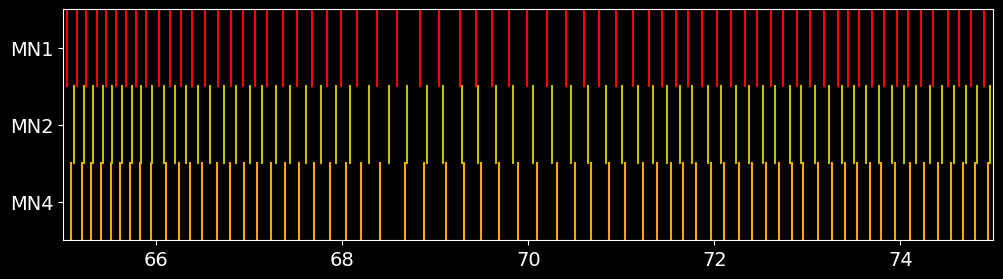

In [322]:
# look at spike times as raster
# visualize as raster
fig, ax = plt.subplots(figsize=(12, 3))

# spike_times_all = [mn1_spike_times, mn2_spike_times,  mn3_spike_times,  mn4_spike_times,  mn5_spike_times]
spike_times_all = [mn4_spike_times, mn2_spike_times, mn1_spike_times]
colors = ['orange', 'y', 'r']
labels = ['MN4', 'MN2', 'MN1']
boundary_ctrs = (line_boundaries[:-1] + line_boundaries[1:])/2.0
xlim = [65, 75]

ax = plot_spike_raster(spike_times_all, ax=ax, labels=labels, colors=colors, xlim=xlim)


Text(0, 0.5, 'state')

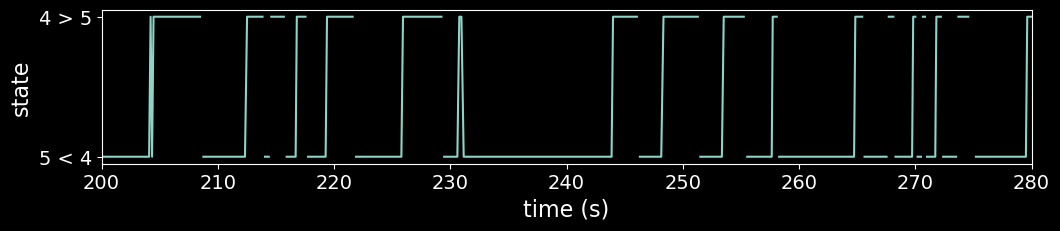

In [37]:
# Look at order of mn2 vs mn4 relative to mn1
# code for states: 1 = mn2 before mn4; 0 = mn4 before mn2; nan = missing one
states = list()
interval_ctrs = list()

for ith in range(mn1_spike_times.size - 1):
    # get TIMES for mn1 spikes that bracket current interval
    start_t = mn1_spike_times[ith]
    end_t = mn1_spike_times[ith + 1]

    # record interval center
    interval_ctr = (start_t + end_t)/2.0
    interval_ctrs.append(interval_ctr)
    
    # get TIME of mn4 and mn5 spikes in this interval
    mn2_t = mn2_spike_times[(mn2_spike_times > start_t) & (mn2_spike_times < end_t)]
    mn4_t = mn4_spike_times[(mn4_spike_times > start_t) & (mn4_spike_times < end_t)]

    # determine state based on order of these two
    if (mn4_t.size != 1) or (mn2_t.size != 1):
        states.append(np.nan)
    else:
        states.append(mn2_t[0] < mn4_t[0])


# convert to array 
states = np.asarray(states)
interval_ctrs = np.asarray(interval_ctrs)

# visualize!
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(interval_ctrs, states, '-')
# # ax.set_axis_off()
ax.set_xlim([200, 280])

ax.set_yticks([0, 1], labels=['5 < 4', '4 > 5'])
ax.set_xlabel('time (s)')
ax.set_ylabel('state')


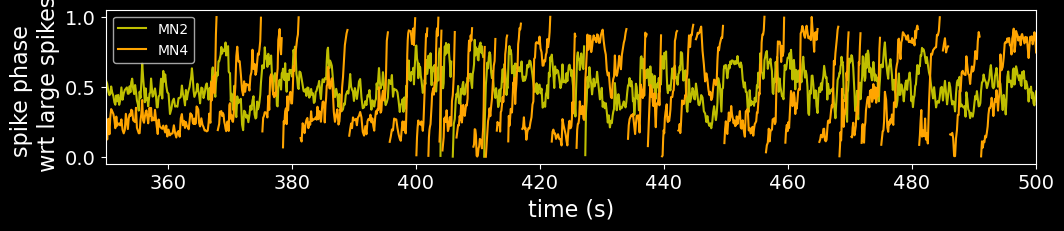

In [61]:
# phase of mn2 and mn4 relative to mn1
mn2_phases = list()
mn4_phases = list()
interval_ctrs = list()

for ith in range(mn1_spike_times.size - 1):
    # get TIMES for mn1 spikes that bracket current interval
    start_t = mn1_spike_times[ith]
    end_t = mn1_spike_times[ith + 1]

    # record interval center
    interval_ctr = (start_t + end_t)/2.0
    interval_ctrs.append(interval_ctr)
    
    # get TIME of mn4 and mn5 spikes in this interval
    mn2_t = mn2_spike_times[(mn2_spike_times > start_t) & (mn2_spike_times < end_t)]
    mn4_t = mn4_spike_times[(mn4_spike_times > start_t) & (mn4_spike_times < end_t)]

    # get phases of mn4 spikes
    if mn4_t.size != 1:
        mn4_phase = np.nan
    else:
        mn4_phase = (mn4_t[0] - start_t)/(end_t - start_t) 

    mn4_phases.append(mn4_phase)

    # get phases of mn2 spikes
    if mn2_t.size != 1:
        mn2_phase = np.nan
    else:
        mn2_phase = (mn2_t[0] - start_t)/(end_t - start_t) 
        
    mn2_phases.append(mn2_phase)

# convert to arrays
mn2_phases = np.asarray(mn2_phases)
mn4_phases = np.asarray(mn4_phases)
interval_ctrs = np.asarray(interval_ctrs)

# visualize!
fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(interval_ctrs, mn2_phases , color='y', label='MN2')
ax.plot(interval_ctrs, mn4_phases , color='orange', label='MN4')
ax.set_xlim([350, 500])

ax.set_xlabel('time (s)')
ax.set_ylabel('spike phase \n wrt large spikes')
ax.legend()

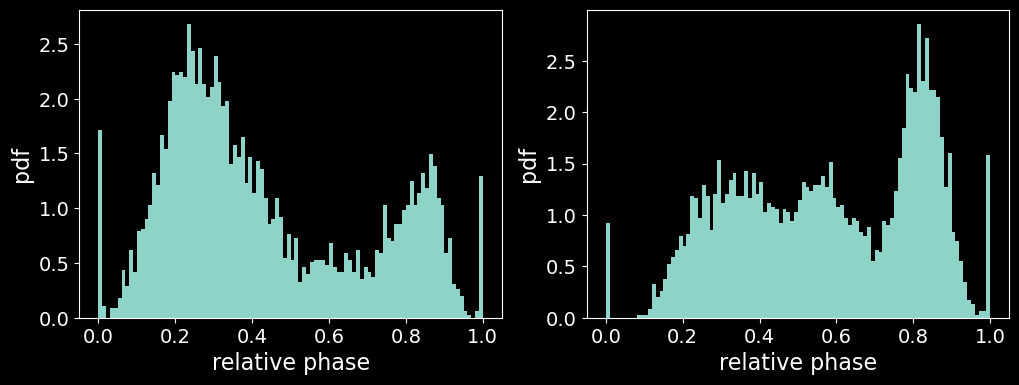

In [70]:
# look at pairwise phases
phases_41 = get_pairwise_phase(mn4_spike_times, mn1_spike_times)
phases_42 = get_pairwise_phase(mn4_spike_times, mn2_spike_times)
phases_all = [phases_41, phases_42]

fig, axes = plt.subplots(1, len(phases_all), figsize=(12,4))
axes = axes.ravel()

for ith, ax in enumerate(axes):
    ax.hist(phases_all[ith], bins=100, density=True)
    ax.set_xlabel('relative phase')
    ax.set_ylabel('pdf')

## Check out another example data file

## Scratch

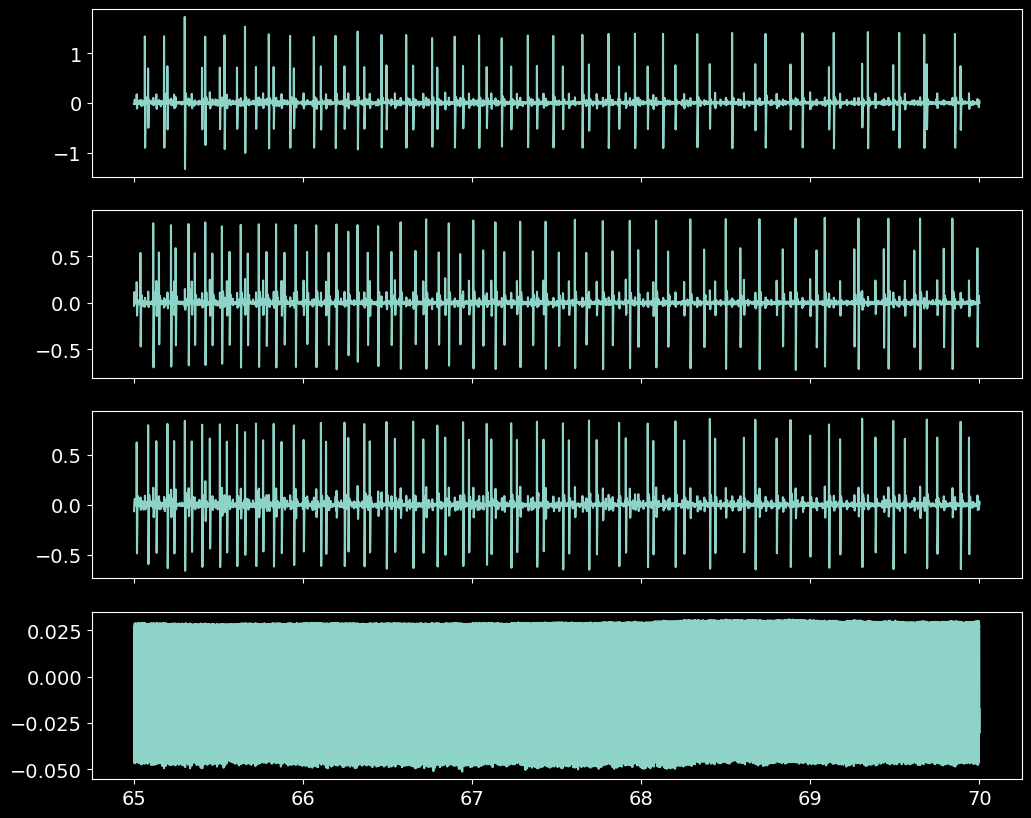

In [63]:
# plot the different signals
n_plots = signal.magnitude.shape[1]

# set x bounds
t_duch = (1/fs)*np.arange(signal.shape[0]) + data[0].segments[0].analogsignals[0].t_start.magnitude
tmin = 0 + t_duch[0]
tmax = 5 + t_duch[0] # 0.25
mask = (t_duch >= tmin) & (t_duch <= tmax)

fig, ax_list = plt.subplots(n_plots, 1, figsize=(12, 2.5*n_plots), sharex=True)
ax_list = ax_list.ravel()

for ith in range(n_plots):
    ax_list[ith].plot(t_duch[mask], signal.magnitude[mask, ith]) 


In [34]:
# data[0].segments[0].analogsignals[0]

AnalogSignal with 4 channels of length 12000001; units mV; datatype float32
name: 'Signal stream 0'
annotations: {'stream_id': '0'}
sampling rate: 20000.00050524251 Hz
time: 64.99999835796189 s to 665.0000332006857 s

In [85]:
# print(data[0].segments[0].events[1].name)
# print(data[0].segments[0].events[1].times)

MN4
[ 65.0834  65.1974  65.2996 ... 664.6196 664.7859 664.9315] s


In [69]:
# okay test our newfound knowledge
signal = data[0].segments[0].analogsignals[0] # read out ephys signals
fs = data[0].segments[0].analogsignals[-1].sampling_rate.magnitude.item()

mn34_sig = signal.magnitude[:, 1]  
mn45_sig = signal.magnitude[:, 2]

# also read out spike times
mn4_spike_times = data[0].segments[0].events[1].times.magnitude

# get time points
t_duch = signal.times.magnitude

# find indices that corrspond to MN spikes
mn4_spike_idx = []
for st in mn4_spike_times:
    sidx = np.argmin(np.abs(t_duch - st))
    mn4_spike_idx.append(sidx)
    

In [70]:
# convert to array
mn4_spike_idx = np.asarray(mn4_spike_idx)


In [82]:
mn45_sig = signal.magnitude[:, 0]  
mn34_sig = signal.magnitude[:, 2]  

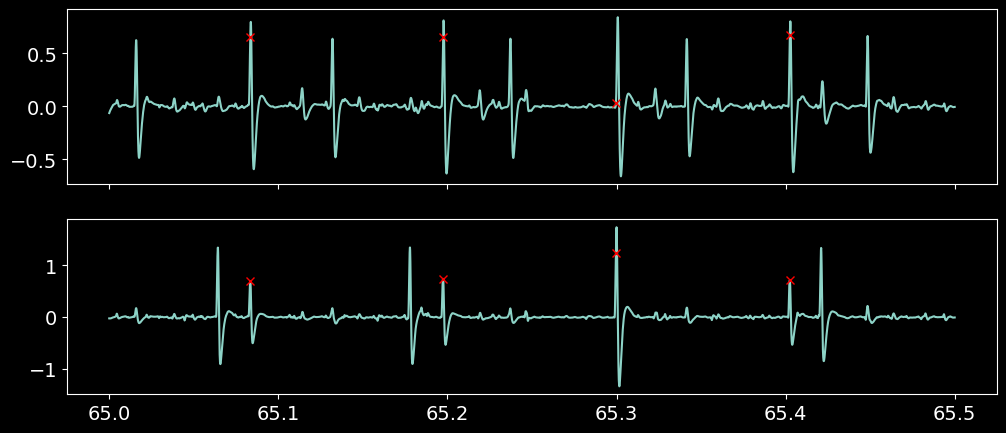

In [84]:
# plot 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5), sharex=True)

tmin = 0 + t_duch[0]
tmax = 0.5 + t_duch[0] # 0.25
mask = (t_duch >= tmin) & (t_duch <= tmax)
mask_spikes = (t_duch[mn4_spike_idx] >= tmin) & (t_duch[mn4_spike_idx] <= tmax)

ax1.plot(t_duch[mask], mn34_sig[mask])
ax1.plot(t_duch[mn4_spike_idx][mask_spikes], mn34_sig[mn4_spike_idx][mask_spikes], 'rx')

ax2.plot(t_duch[mask], mn45_sig[mask])
ax2.plot(t_duch[mn4_spike_idx][mask_spikes], mn45_sig[mn4_spike_idx][mask_spikes], 'rx')

In [127]:
# def neigh_block(details, n, sigma):
#     res = []
#     L0 = int(np.log2(n) // 2)
#     L1 = max(1, L0 // 2)
#     L = L0 + 2 * L1
#     def nb_beta(sigma, L, detail):
#         S2 = np.sum(detail ** 2)
#         lmbd = 4.50524 # solution of lmbd - log(lmbd) = 3
#         beta = (1 - lmbd * L * sigma**2 / S2)
#         return max(0, beta)
#     for d in details:
#         d2 = d.copy()
#         for start_b in range(0, len(d2), L0):
#             end_b = min(len(d2), start_b + L0)
#             start_B = start_b - L1
#             end_B = start_B + L
#             if start_B < 0:
#                 end_B -= start_B
#                 start_B = 0
#             elif end_B > len(d2):
#                 start_B -= end_B - len(d2)
#                 end_B = len(d2)
#             assert end_B - start_B == L
#             d2[start_b:end_b] *= nb_beta(sigma, L, d2[start_B:end_B])
#         res.append(d2)
    
#     return res


## Aside: try wavelet for detrending?

Text(0, 0.5, 'emg (V)')

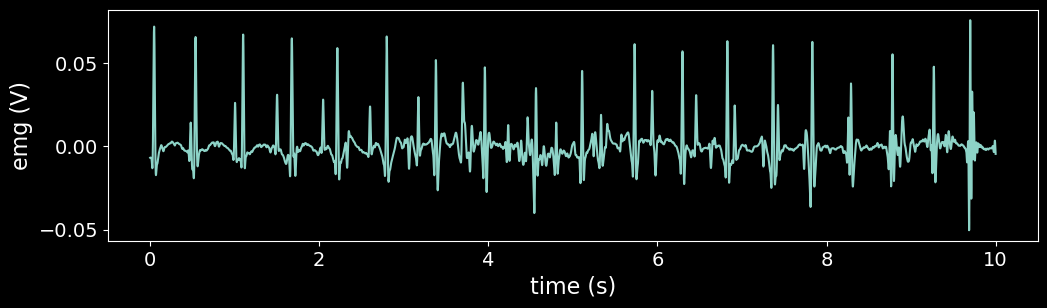

In [143]:
# first try simple denoising
wavelet = "sym6"  # "sym12"  # "db12"
sig = emg_filt.copy()
coeffs = pywt.wavedec(sig, wavelet)  # "sym12"
approx = coeffs[0]
details = coeffs[1:]
details_nb = neigh_block(details, len(sig), 0.15)  # 0.03  # 0.02
sig_denoised = pywt.waverec([approx] + details_nb, wavelet)

# visualize
tmin = 0
tmax = 10
mask = (t >= tmin) & (t <= tmax)

fig, ax = plt.subplots(figsize=(12, 3))

# ax.plot(t[mask], emg_filt_detrend[mask])
ax.plot(t[mask], sig[mask] - sig_denoised[mask])

ax.set_xlabel('time (s)')
ax.set_ylabel('emg (V)')